In [13]:
import javalang
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding, Dense, Input, Concatenate
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))
print("Está usando GPU:", tf.test.is_gpu_available())

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Está usando GPU: True


In [14]:
dataset = pd.read_csv("../dataset/dataset_v2.csv")

def tokenize_and_normalize(source_code):
    tokens = list(javalang.tokenizer.tokenize(source_code))
    normalized_tokens = []
    for token in tokens:
        if isinstance(token, javalang.tokenizer.Identifier):
            normalized_tokens.append("IDENT")
        elif isinstance(token, javalang.tokenizer.String):
            normalized_tokens.append("STRING")
        elif isinstance(token, javalang.tokenizer.Integer):
            normalized_tokens.append("INT")
        elif isinstance(token, javalang.tokenizer.FloatingPoint):
            normalized_tokens.append("FLOAT")
        else:
            normalized_tokens.append(token.value)
    return normalized_tokens

all_tokens = []
for _, row in dataset.iterrows():
    code1 = row.iloc[0]
    code2 = row.iloc[1]
    all_tokens.extend(tokenize_and_normalize(code1))
    all_tokens.extend(tokenize_and_normalize(code2))

encoder = LabelEncoder()
encoder.fit(list(set(all_tokens)))

LabelEncoder()

In [15]:
def tokens_to_sequence(tokens):
    return encoder.transform(tokens)

def preprocess_pair(code1, code2):
    tokens_1 = tokenize_and_normalize(code1)
    tokens_2 = tokenize_and_normalize(code2)
    seq_1 = tokens_to_sequence(tokens_1)
    seq_2 = tokens_to_sequence(tokens_2)
    return seq_1, seq_2

In [16]:
seq_1_list, seq_2_list, labels = [], [], []
for _, row in dataset.iterrows():
    code1 = row.iloc[0]
    code2 = row.iloc[1]
    seq_1, seq_2 = preprocess_pair(code1, code2)
    seq_1_list.append(seq_1)
    seq_2_list.append(seq_2)
    labels.append(row.iloc[2])

MAX_LEN = 300
seq_1_list = pad_sequences(seq_1_list, maxlen=MAX_LEN)
seq_2_list = pad_sequences(seq_2_list, maxlen=MAX_LEN)
labels = np.array(labels)

X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test = train_test_split(
    seq_1_list, seq_2_list, labels, test_size=0.2, random_state=42
)

In [ ]:
from keras.layers import LSTM, Bidirectional

vocab_size = len(encoder.classes_)
embedding_dim = 128

def build_encoder():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAX_LEN, mask_zero=True),
        Bidirectional(LSTM(64)),
        Dense(128, activation='relu')
    ])
    return model

encoder_model = build_encoder()

input_1 = Input(shape=(MAX_LEN,))
input_2 = Input(shape=(MAX_LEN,))

encoded_1 = encoder_model(input_1)
encoded_2 = encoder_model(input_2)

merged = Concatenate()([encoded_1, encoded_2])
output = Dense(1, activation='sigmoid')(merged)

siamese_model = Model(inputs=[input_1, input_2], outputs=output)
siamese_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

In [18]:
# Train model
history = siamese_model.fit(
    [X_train_1, X_train_2], y_train,
    epochs=10,
    batch_size=8,
    validation_split=0.2
)

Epoch 1/10
112/112 [==============================] - 358s 3s/step - loss: 0.4342 - accuracy: 0.8380 - val_loss: 0.3297 - val_accuracy: 0.8744
Epoch 2/10
112/112 [==============================] - 335s 3s/step - loss: 0.2812 - accuracy: 0.9055 - val_loss: 0.3571 - val_accuracy: 0.8565
Epoch 3/10
112/112 [==============================] - 340s 3s/step - loss: 0.2497 - accuracy: 0.9224 - val_loss: 0.3047 - val_accuracy: 0.9013
Epoch 4/10
112/112 [==============================] - 342s 3s/step - loss: 0.2281 - accuracy: 0.9291 - val_loss: 0.4002 - val_accuracy: 0.8655
Epoch 5/10
112/112 [==============================] - 342s 3s/step - loss: 0.2204 - accuracy: 0.9280 - val_loss: 0.2926 - val_accuracy: 0.9238
Epoch 6/10
112/112 [==============================] - 338s 3s/step - loss: 0.1951 - accuracy: 0.9415 - val_loss: 0.2968 - val_accuracy: 0.9193
Epoch 7/10
112/112 [==============================] - 345s 3s/step - loss: 0.1802 - accuracy: 0.9415 - val_loss: 0.3105 - val_accuracy: 0.9103

In [19]:
test_similarity = siamese_model.predict([X_test_1, X_test_2])

threshold = 0.5
pred_labels = (test_similarity.flatten() > threshold).astype(int)
accuracy = np.mean(pred_labels == y_test)
print(f"Test set accuracy (threshold={threshold}): {accuracy:.4f}")

9/9 [==============================] - 8s 482ms/step
Test set accuracy (threshold=0.5): 0.9065


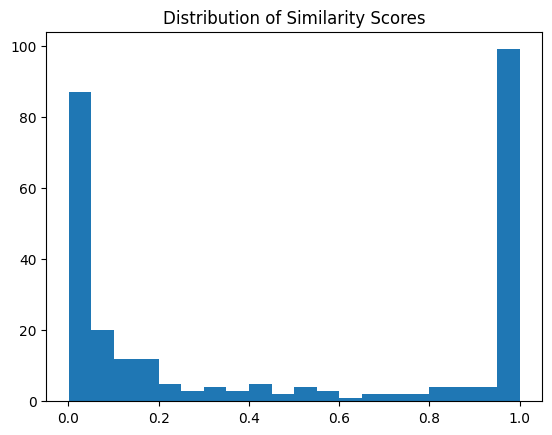

In [20]:
plt.hist(test_similarity.flatten(), bins=20)
plt.title("Distribution of Similarity Scores")
plt.show()

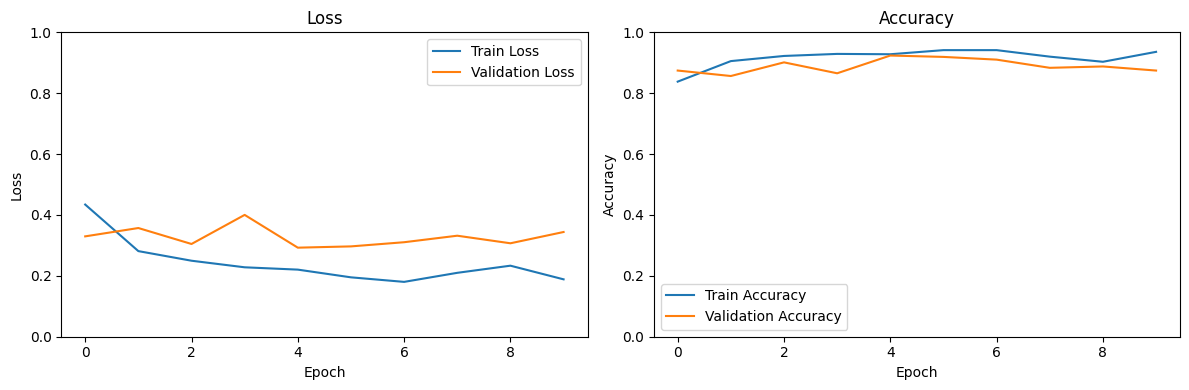

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12, 4))

# Loss
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_ylim((0, 1))
ax1.set_title('Loss')

# Accuracy
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_ylim((0, 1))
ax2.set_title('Accuracy')

plt.tight_layout()
plt.show()

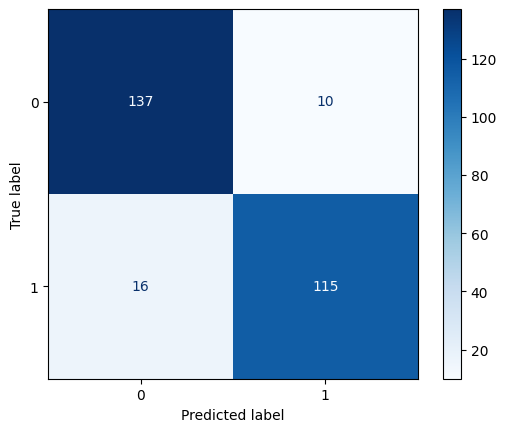

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [23]:
from sklearn.metrics import f1_score, recall_score, precision_score

recall = recall_score(y_test, pred_labels)
precision = precision_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Recall: 0.8779
Precision: 0.9200
F1 Score: 0.8984


In [ ]:
siamese_model.save_weights("../siamese_model.weights.h5")